# Building a Robot Judge
## ETH Zurich, Spring 2019

## Problem Set 3

Author: Philipp Nikolaus

## 1. Environment

In [110]:
import json
import logging
import os
import pickle
import random
import string
from collections import Counter
from itertools import groupby
from string import punctuation

import keras.backend as K
import numpy as np
import pandas as pd
import spacy
import statsmodels.api as sm
import tensorflow as tf
import umap
from gensim import corpora
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.models.tfidfmodel import TfidfModel
from keras.layers import Dense, Input, Reshape
from keras.layers.merge import Concatenate
from keras.models import Model
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import deepiv.architectures as architectures
import deepiv.densities as densities
from deepiv.models import Response, Treatment

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


## 2. Data prep

In [2]:
n_samples = None # use only a subset of the available data for computational reasons
seed = 42
random.seed(seed)

In [4]:
with open("./data/cases_preprocessed_full.pkl", "rb") as f:
    data = pickle.load(f)

## 3. Word embedding

In [9]:
## fit a w2v model with window size 2 and embedding dimensionality 128

corpus = [case["doc_clean"] for case in data.values()]

model_1 = Word2Vec(
        sentences=corpus,
        size=128,
        window=2,
        min_count=10
)

model_1.train(corpus, total_examples=len(corpus), epochs=10)

(87102240, 102744890)

In [5]:
# model_1.save("./data/w2v_model_1.model")
model_1 = Word2Vec.load("./data/w2v_model_1.model")

In [6]:
model_1.wv.most_similar(positive=["race"],topn=10)

[('racial', 0.628469705581665),
 ('gender', 0.6050706505775452),
 ('sex', 0.57304447889328),
 ('ethnicity', 0.5586254596710205),
 ('ethnic', 0.482021689414978),
 ('pretextual', 0.47954535484313965),
 ('invidious', 0.47475823760032654),
 ('stereotype', 0.45603665709495544),
 ('racially', 0.4546758830547333),
 ('male', 0.4522125720977783)]

In [13]:
## fit a w2v model with window size 16 and embedding dimensionality 128

model_2 = Word2Vec(
    sentences=corpus,
    size=128,
    window=16,
    min_count=10
)

model_2.train(corpus, total_examples=len(corpus), epochs=10)

(87099819, 102744890)

In [7]:
# model_2.save("./data/w2v_model_2.model")
model_2 = Word2Vec.load("./data/w2v_model_2.model")

In [8]:
model_2.wv.most_similar(positive=["race"],topn=10)

[('racial', 0.704522967338562),
 ('ethnic', 0.6393071413040161),
 ('racially', 0.574921190738678),
 ('ethnicity', 0.5647216439247131),
 ('negroes', 0.5499587655067444),
 ('districting', 0.5492852926254272),
 ('systematically', 0.5425291061401367),
 ('gender', 0.5337997078895569),
 ('black', 0.5318843126296997),
 ('animus', 0.5256729125976562)]

In [9]:
def plot_2d(w2v_model, n_samples=100):

    vocab = w2v_model.wv.vocab

    embedding_array = np.zeros((n_samples,128))
    word_list = []

    for i, word in enumerate(random.sample(vocab.keys(), k=n_samples)):
        embedding_array[i,:] = w2v_model.wv[word]
        word_list.append(word)

    umapper = umap.UMAP(random_state=seed)
    x_umap = umapper.fit_transform(embedding_array)

    tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=seed, verbose=0)
    x_tsne = tsne.fit_transform(embedding_array)

    plt.scatter(x_umap[:,0], x_umap[:,1])
    plt.title("UMAP 2D Embedding")
    for i, word in enumerate(word_list):
        plt.text(
            x_umap[i,0], x_umap[i,1]+0.05,
            word,
            horizontalalignment='left',
            verticalalignment='bottom',
            size='medium'
        ).set_size(10)
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")

    plt.show()

    fig = plt.Figure(figsize=(120,120))
    plt.scatter(x_tsne[:,0], x_tsne[:,1])
    plt.title("TSNE 2D Embedding")
    for i, word in enumerate(word_list):
        plt.text(
            x_tsne[i,0], x_tsne[i,1]+0.05,
            word,
            horizontalalignment='left',
            verticalalignment='bottom',
            size='medium'
        ).set_size(10)
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
    plt.show()


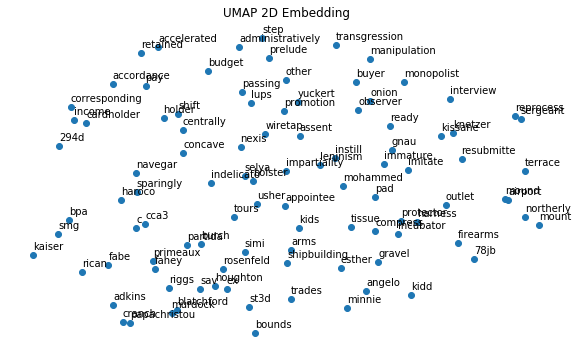

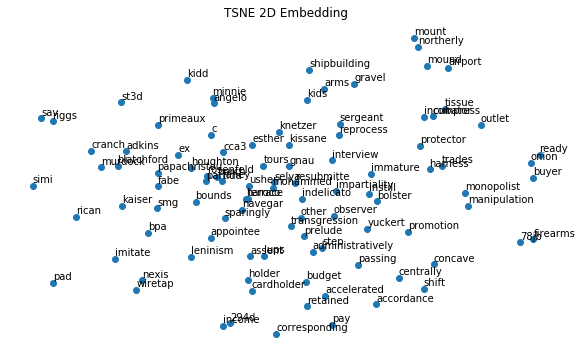

In [11]:
plot_2d(model_1)

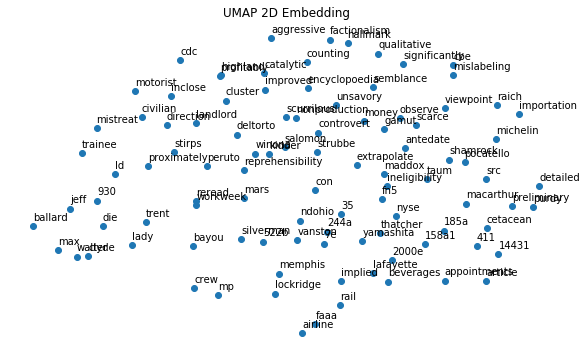

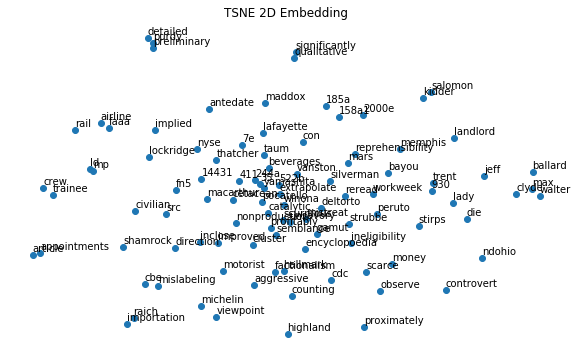

In [12]:
plot_2d(model_2)

## 4. Partisanship

In [13]:
# define a function that extracts the closest n adjectives from a word.
nlp = spacy.load('en_core_web_sm')

def get_top_adjectives(model, word, ntop):
    count = 0
    adjectives = []
    closest100 = model.wv.most_similar(positive=[word],topn=500)
    i = 0
    while count < ntop:
        if i == 100:
            break
        token = nlp(closest100[i][0])[0]
        if token.pos_ == "ADJ":
            adjectives.append(token.text)
            count+=1
        i+=1
        
    return(adjectives)


In [14]:
corpus_dem = []
corpus_rep = []

for case in tqdm(data.values()):
    if case["x_republican"]==0:
        corpus_dem.append(case["doc_clean"])
    elif case["x_republican"]==1:
        corpus_rep.append(case["doc_clean"])
    else:
        continue

print("")
print("")
print("Case counts")
print(f"-- democrat: {len(corpus_dem)}")
print(f"-- republican: {len(corpus_rep)}")

100%|██████████| 5762/5762 [00:00<00:00, 954146.62it/s]

Case counts
-- democrat: 2450
-- republican: 2417



In [18]:
model_dem = Word2Vec(
    sentences=corpus_dem,
    size=128,
    window=16,
    min_count=10
)

model_dem.train(corpus_dem, total_examples=len(corpus_dem), epochs=10)

In [19]:
# model_dem.save("./data/w2v_model_dem.model")
model_dem = Word2Vec.load("./data/w2v_model_dem.model")

In [ ]:
model_rep = Word2Vec(
    sentences=corpus_rep,
    size=128,
    window=16,
    min_count=10
)

model_rep.train(corpus_rep, total_examples=len(corpus_rep), epochs=10)

In [20]:
# model_rep.save("./data/w2v_model_rep.model")
model_rep = Word2Vec.load("./data/w2v_model_rep.model")

In [21]:
get_top_adjectives(model_dem, "woman", 10)

['pregnant',
 'female',
 'stereotypical',
 'unmarried',
 'blind',
 'unborn',
 'sick',
 'sexual',
 'neutral',
 'fetal']

In [22]:
get_top_adjectives(model_rep, "woman", 10)

['unmarried',
 'pregnant',
 'female',
 'minor',
 'immoral',
 'elderly',
 'sexual',
 'immature',
 'unequal',
 'hispanic']

## 5. Deep IV

In [23]:
## tfidf features from lemmatized case strings

dictionary = corpora.Dictionary([case["doc_clean"] for case in data.values()])
dictionary.filter_n_most_frequent(5)
cbow_corpus = [dictionary.doc2bow(case["doc_clean"]) for case in data.values()]

# tfidf_mod = TfidfModel(cbow_corpus)
# tfidf_corpus = [tfidf_mod[case_cbow] for case_cbow in cbow_corpus]

In [24]:
lda = LdaModel(
    cbow_corpus, 
    num_topics=10, 
    id2word=dictionary, 
    passes=3, 
    random_state=seed
)

In [123]:
lda.show_topics(formatted=False)

[(0,
  [('state', 0.018358793),
   ('sct', 0.015337832),
   ('us', 0.0137907965),
   ('district', 0.00908179),
   ('school', 0.00781548),
   ('law', 0.007135836),
   ('led2d', 0.006479089),
   ('right', 0.0058561475),
   ('supreme', 0.0055752206),
   ('amendment', 0.0055679046)]),
 (1,
  [('commission', 0.010957711),
   ('union', 0.009532304),
   ('act', 0.009280837),
   ('board', 0.008563569),
   ('employee', 0.007665189),
   ('company', 0.007135131),
   ('order', 0.00678398),
   ('co', 0.006191176),
   ('labor', 0.0055807745),
   ('price', 0.004895471)]),
 (2,
  [('states', 0.008886507),
   ('united', 0.008785767),
   ('act', 0.008419106),
   ('government', 0.0071652844),
   ('defendant', 0.0065098493),
   ('sct', 0.005890022),
   ('statute', 0.00583894),
   ('us', 0.005692778),
   ('district', 0.0044286037),
   ('offense', 0.0044006654)]),
 (3,
  [('claim', 0.0145398425),
   ('district', 0.013399139),
   ('plaintiff', 0.0116304085),
   ('action', 0.006888495),
   ('f3d', 0.006469525

In [26]:
lda[dictionary.doc2bow(data["X3JGGO"]["doc_clean"])]

[(1, 0.066316105), (5, 0.13388723), (6, 0.4785471), (7, 0.31229916)]

In [27]:
for case_id, case in tqdm(data.items()):
    doc_lda = np.zeros(10)
    for topic, prob in lda[dictionary.doc2bow(case["doc_clean"])]:
        doc_lda[topic] = prob
    
    data[case_id]["doc_lda"] = doc_lda

100%|██████████| 5762/5762 [00:10<00:00, 554.12it/s]


In [28]:
judge_doc_embeddings = {}

for case in tqdm(data.values()):
    judge_id = case["judge_id"]

    if not np.isnan(judge_id):
        if not judge_id in judge_doc_embeddings.keys():
            judge_doc_embeddings[judge_id] = [case["doc_lda"].tolist()]
        else:
            judge_doc_embeddings[judge_id].append(case["doc_lda"].tolist())

judge_embeddings = {}
for judge_id, doc_embeddings in judge_doc_embeddings.items():
    judge_embeddings[judge_id] = np.mean(doc_embeddings, axis=0)

100%|██████████| 5762/5762 [00:00<00:00, 216600.01it/s]


In [86]:
P = []
Z = []
X = []
y = []

for case_id in tqdm(data.keys()):
    if np.isnan(data[case_id]["judge_id"]):
        continue
    else:
        P.append(data[case_id]["doc_lda"].tolist())
        Z.append(judge_embeddings[data[case_id]["judge_id"]].tolist())
        X.append([data[case_id]["x_republican"],data[case_id]["log_cites"]])
        y.append(data[case_id]["case_reversed"])

P = np.array(P)
Z = np.array(Z)
X = np.array(X)
y = np.expand_dims(np.array(y), axis=1)

100%|██████████| 5762/5762 [00:00<00:00, 179396.51it/s]


In [87]:
nan_mask = [not x for x in np.any(np.isnan(X),axis=1)]
sum(nan_mask)

4389

In [88]:
P.shape

(4878, 10)

In [89]:
P = StandardScaler().fit_transform(P[nan_mask,:])
Z = StandardScaler().fit_transform(Z[nan_mask,:])
X = StandardScaler().fit_transform(X[nan_mask,:])
y = y[nan_mask]

In [91]:
instruments = Input(shape=(Z.shape[1],), name="instruments")
features = Input(shape=(X.shape[1],), name="features")
treatment_input = Concatenate(axis=1)([instruments, features])

In [ ]:
hidden = [32, 32]
act = "relu"
n_components = 3
dropout_rate = 0.1
epochs = 50
batch_size=64

In [92]:
# Build and fit treatment model

est_treat = architectures.feed_forward_net(treatment_input, lambda x: densities.mixture_of_gaussian_layer(x, 10, n_components),
                                           hidden_layers=hidden,
                                           dropout_rate=dropout_rate, l2=0.001,
                                           activations=act)

treatment_model = Treatment(inputs=[instruments, features], outputs=est_treat)
treatment_model.compile(
    'adam',
    loss="mixture_of_gaussians",
    n_components=n_components,
    n_dims=10
)

treatment_model.fit([Z, X], P, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/50
4389/4389 [==============================] - 2s 444us/step - loss: 16.5529
Epoch 2/50
4389/4389 [==============================] - 0s 46us/step - loss: 14.1879
Epoch 3/50
4389/4389 [==============================] - 0s 40us/step - loss: 13.4292
Epoch 4/50
4389/4389 [==============================] - 0s 39us/step - loss: 12.8255
Epoch 5/50
4389/4389 [==============================] - 0s 40us/step - loss: 12.3219
Epoch 6/50
4389/4389 [==============================] - 0s 41us/step - loss: 11.9416
Epoch 7/50
4389/4389 [==============================] - 0s 43us/step - loss: 11.7571
Epoch 8/50
4389/4389 [==============================] - 0s 41us/step - loss: 11.5292
Epoch 9/50
4389/4389 [==============================] - 0s 43us/step - loss: 11.3174
Epoch 10/50
4389/4389 [==============================] - 0s 40us/step - loss: 11.2340
Epoch 11/50
4389/4389 [==============================] - 0s 42us/step - loss: 11.1107
Epoch 12/50
4389/4389 [==============================] - 0s 41

In [93]:
# Build and fit response model

treatment = Input(shape=(P.shape[1],), name="treatment")
response_input = Concatenate(axis=1)([features, treatment])

est_response = architectures.feed_forward_net(response_input, Dense(1),
                                              activations=act,
                                              hidden_layers=hidden,
                                              l2=0.001,
                                              dropout_rate=dropout_rate)

response_model = Response(treatment=treatment_model,
                          inputs=[features, treatment],
                          outputs=est_response)
response_model.compile('adam', loss='mse')
response_model.fit([Z, X], y, epochs=epochs, verbose=1,
                   batch_size=batch_size, samples_per_batch=2)



Epoch 1/50
68/68 [==============================] - 2s 26ms/step - loss: 0.3431
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 0.2992
Epoch 3/50
68/68 [==============================] - 0s 3ms/step - loss: 0.2898
Epoch 4/50
68/68 [==============================] - 0s 3ms/step - loss: 0.2790
Epoch 5/50
68/68 [==============================] - 0s 3ms/step - loss: 0.2746
Epoch 6/50
68/68 [==============================] - 0s 3ms/step - loss: 0.2716
Epoch 7/50
68/68 [==============================] - 0s 3ms/step - loss: 0.2682
Epoch 8/50
68/68 [==============================] - 0s 3ms/step - loss: 0.2644
Epoch 9/50
68/68 [==============================] - 0s 3ms/step - loss: 0.2637
Epoch 10/50
68/68 [==============================] - 0s 4ms/step - loss: 0.2600
Epoch 11/50
68/68 [==============================] - 0s 4ms/step - loss: 0.2575
Epoch 12/50
68/68 [==============================] - 0s 3ms/step - loss: 0.2574
Epoch 13/50
68/68 [=============================

In [96]:
gaussian_params = treatment_model.predict([Z,X])

In [102]:
def collect_gaussian_mix_mean(params):
    mu = params[:30]
    log_sigma = params[30:60]
    pi = params[60:90]

    mu = mu.reshape((10,3))
    pi = pi.reshape((10,3))
    mix_mean = mu * pi

    return mix_mean.sum(axis=1)

In [104]:
P_hat = np.zeros(P.shape)
for i in range(P_hat.shape[0]):
    P_hat[i,:] = collect_gaussian_mix_mean(gaussian_params[i,:])

In [111]:
logreg = LogisticRegression()
logreg = logreg.fit(P_hat, y)

In [122]:
for i, coef in enumerate(logreg.coef_[0].tolist()):
    print(f"Topic {i}: {coef}")

Topic 0: -0.1243736055780834
Topic 1: -0.099666179886437
Topic 2: -0.20145509174586534
Topic 3: -0.03636063976455842
Topic 4: -0.23797248104273144
Topic 5: -0.07377703745741584
Topic 6: -0.48231116521306033
Topic 7: -0.3613564395959944
Topic 8: -0.5469646853258312
Topic 9: -0.11257444445861087
